### Prepare data for boxplots with one sell

In [70]:
import mne       # импорт библиотек  
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile
import os
from matplotlib import pyplot as plt
import seaborn as sns

GEST = 5          # количество основных жестов (кроме 'битых' данных)
PL = 3            # количество пилотов (независимых рядов данных)
SENS = 50         # количество датчиков

gestures = ['"open"',  # 0
            '"пистолет"',  # 1
            'сгиб большого пальца',  # 2
            '"ok"',  # 3
            '"grab"',  # 4
            '"битые" данные',  # -1
            ]

PATH = 'data'

# изменяем исходный словарь, чтобы далее не распаковывать архив при чтении данных
mounts = {
    1 : {
        'path_X_train' : 'X_train_1.npy',
        'path_y_train' : 'y_train_1.npy',
        'path_X_test_dataset' : 'X_test_dataset_1.pkl',
    },
    2 : {
        'path_X_train' : 'X_train_2.npy',
        'path_y_train' : 'y_train_2.npy',
        'path_X_test_dataset' : 'X_test_dataset_2.pkl',
    },
    3 : {
        'path_X_train' : 'X_train_3.npy',
        'path_y_train' : 'y_train_3.npy',
        'path_X_test_dataset' : 'X_test_dataset_3.pkl',
    }
}

# читаем данные из zip-архива
path_to_zip = os.path.join(PATH, 'motorica-advanced-gesture-classification.zip')

for mount_name, mount in mounts.items():
    mount['X_train'] = np.load(path_to_zip)[mount['path_X_train']]
    mount['y_train'] = np.load(path_to_zip)[mount['path_y_train']]

# с помощью библиотеки mne переводим данные в потоковый формат     
SFREQ = 1000.0 / 33


for mount_name, mount in mounts.items():
    X_train = mount['X_train']
    y_train = mount['y_train']
    
    raw = mne.io.RawArray(
        data=X_train.T,
        info=mne.create_info(
            ch_names=list(np.arange(50).astype(str)),
            sfreq=SFREQ,
            ch_types='eeg'
        )
    )
    raw_y = mne.io.RawArray(
        data=y_train.reshape(1,-1),
        info=mne.create_info(
            ch_names=['y'],
            sfreq=SFREQ,
            ch_types='misc'
        )
    )
    raw = raw.add_channels([raw_y])
    
    mount['raw'] = raw

# вырезаем участки без перехода в 'X_train_plain','y_train_plain'
t_int, t_clear = 77, 46   # фактически вместо t_clear = 46 устанавливаем tmin=-1 * 1.5

for mount_name, mount in mounts.items():
    raw = mount['raw']
    y_train = mount['y_train']
    
    events = np.where(np.abs(np.diff(y_train)) > 0)[0]
    
    events = np.stack([
        events,
        np.zeros_like(events),
        np.zeros_like(events)
    ], axis=1)
    
    epochs = mne.Epochs(
        raw,
        events=events,
        tmin=-1 * 1.5,
        tmax=1 * 0,
        preload=True,
        baseline=None,
        picks='all'
    )
    
    X_train_nn_ = epochs.copy().pick_types(eeg =True)._data.swapaxes(1, 2)
    y_train_nn_ = epochs.copy().pick_types(misc=True)._data.swapaxes(1, 2)
    print(X_train_nn_.shape, y_train_nn_.shape)
        
    i_broken = np.unique(np.where(y_train_nn_ == -1)[0])               # удаляем битые данные
    print('битые данные ', i_broken)
    X_train_nn = np.delete(X_train_nn_, i_broken, axis = 0)
    y_train_nn = np.delete(y_train_nn_, i_broken, axis = 0)
    
    mount['X_train_plain'] = X_train_nn
    mount['y_train_plain'] = y_train_nn.astype(np.int8)
    print(X_train_nn.shape, y_train_nn.shape)    

# Объединяем нарезку по X и по y в потоки данных и переводим в формат DataFrame
for mount_name, mount in mounts.items():
    X_train_plain = mount['X_train_plain']
    y_train_plain = mount['y_train_plain']
    
    X_train_plain_df = pd.DataFrame(columns=[f'sen_{s}' for s in range(SENS)])
    y_train_plain_df = pd.DataFrame(columns=['Class'])
    for samp in range(X_train_plain.shape[0]):
        xx = pd.DataFrame(data=X_train_plain[samp], columns=[f'sen_{s}' for s in range(SENS)])
        X_train_plain_df = pd.concat([X_train_plain_df, xx], ignore_index=True)
        yy = pd.DataFrame(data=y_train_plain[samp], columns=['Class'])
        y_train_plain_df = pd.concat([y_train_plain_df, yy], ignore_index=True)
    mount['X_train_plain_df'] = X_train_plain_df
    y_train_plain_df = y_train_plain_df['Class'].apply(int)
    mount['y_train_plain_df'] = y_train_plain_df

# Объединяем потоки X и y в формате DataFrame и добавляем колонку 
# с характеристикой начало-середина-конец данных
for mount_name, mount in mounts.items():
    X_train_plain_df = mount['X_train_plain_df']
    y_train_plain_df = mount['y_train_plain_df']
    Xy_train_plain_df = pd.concat([X_train_plain_df, y_train_plain_df], axis=1)
    Xy_train_plain_df['Class_name'] = Xy_train_plain_df['Class'].apply(lambda x: gestures[x])
    t_th = X_train_plain_df.shape[0] // 3
    Xy_train_plain_df['b_e'] = Xy_train_plain_df.apply(lambda row: 'b' if row.name <= t_th 
                                                       else ('e' if row.name >= t_th * 2
                                                       else 'p'), axis=1)
    mount['Xy_train_plain_df'] = Xy_train_plain_df
        

Creating RawArray with float64 data, n_channels=50, n_times=24030
    Range : 0 ... 24029 =      0.000 ...   792.957 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=24030
    Range : 0 ... 24029 =      0.000 ...   792.957 secs
Ready.
Creating RawArray with float64 data, n_channels=50, n_times=23202
    Range : 0 ... 23201 =      0.000 ...   765.633 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=23202
    Range : 0 ... 23201 =      0.000 ...   765.633 secs
Ready.
Creating RawArray with float64 data, n_channels=50, n_times=23177
    Range : 0 ... 23176 =      0.000 ...   764.808 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=23177
    Range : 0 ... 23176 =      0.000 ...   764.808 secs
Ready.
Not setting metadata
277 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 277 events and 46 original time points ...
0 bad epochs dropped
(277, 46, 50) (277, 46, 

### Show boxplots with one sell

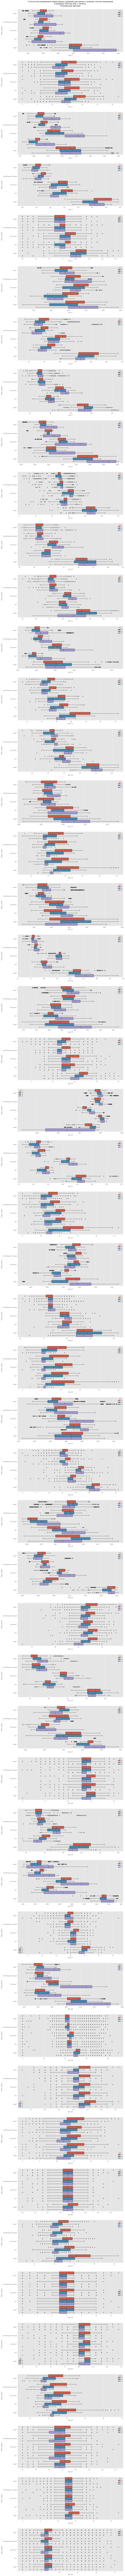

In [71]:
mount_name = 1                 # выбираем номер пилота для построения боксплотов
Xy_train_plain_df = mounts[mount_name]['Xy_train_plain_df']

plt.style.use('ggplot')
fig, axes = plt.subplots(SENS, 1, figsize=(16, 400))

for sens in range(SENS):
    boxplot = sns.boxplot(data=Xy_train_plain_df, x=f'sen_{sens}', y='Class_name', 
                            ax=axes[sens], hue='b_e', orient='h', 
                            width=0.9, dodge=True, showmeans=True)

axes[0].set_title(f'Статистика изменения характерных уровней датчиков в течение снятия показаний\n'
               + f'в разрезе жестов для {mount_name} пилота.\n'
               + f'Очищенные данные\n', 
               fontsize=16);
# plt.show()